In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from src import utility as utils

In [ ]:
%load_ext jupyter_black

In [ ]:
file_names = [x for x in os.listdir() if ".xlsb" in x]
data_dict = {
    "2016": "CMI TA DB 2016 Datasheet v02 2024-06-17.xlsb",
    "2017": "CMI TA DB 2017 Datasheet v02 2024-06-17.xlsb",
    "2018": "CMI TA DB 2018 Datasheet v01 2022-05-20.xlsb",
    "2019": "CMI TA DB 2019 Datasheet v01 2022-05-20.xlsb",
    "2020": "CMI TA DB 2020 Datasheet v01 2022-05-20.xlsb",
}

In [4]:
df = utils.compile_data(
    data_dict,
    r"C:\Users\u013709\IFoA\Secure File Exchange 2024-08-28 20-00-20\CMI WP162 TA DB 2016-2020 datasheets",
)

2535449


In [5]:
df.columns

Index(['ProductCategory', 'Gender', 'SmokerStatus', 'DistributionChannel',
       'CommencementYear', 'JointLifeStatus', 'SumAssuredBand', 'Age',
       'Duration', 'LivesExposure', 'AmountsExposure', 'IncurredClaims',
       'AmountIncurred', 'ExpectedClaims', 'ExpectedAmountClaims',
       'ComparatorTable', 'CalendarYear', 'unique_id', 'holdout',
       'random_fold'],
      dtype='object')

In [6]:
combined_df = df.drop(["ComparatorTable", "unique_id"], axis=1)  # "CalendarYear",

In [ ]:
combined_df["LivesExposure"] = combined_df["LivesExposure"].replace(0, 0.5)  #half an year exposure for missing exposures

In [8]:
combined_df["Actual_deaths"] = (
    combined_df["AmountIncurred"] / combined_df["AmountsExposure"]
)
combined_df["Actual_deaths_lives"] = (
    combined_df["IncurredClaims"] / combined_df["LivesExposure"]
)
combined_df["Expected_deaths"] = (
    combined_df["ExpectedAmountClaims"] / combined_df["AmountsExposure"]
)
combined_df["Expected_deaths_lives"] = (
    combined_df["ExpectedClaims"] / combined_df["LivesExposure"]
)

In [ ]:
combined_df = combined_df[
    combined_df["LivesExposure"] != 0
]  

In [10]:
combined_df["CommencementYear"].unique()

array(['2001', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
       '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '1999 or earlier', '2000', '2002', '2017', '2018', '2019', '2020'],
      dtype=object)

In [11]:
def CommencementYear_change(CommencementYear):
    if CommencementYear == "1999 or earlier":
        new_cy = 1
    else:
        new_cy = max(int(CommencementYear) - 1999 + 1, 0)
    return new_cy

In [12]:
def CalYear_change(CalendarYear):
    if CalendarYear == "1999 or earlier":
        new_cy = 1
    else:
        new_cy = max(int(CalendarYear) - 2016 + 1, 0)
    return new_cy

In [13]:
combined_df["CommencementYear"] = combined_df["CommencementYear"].apply(
    CommencementYear_change
)

In [14]:
combined_df["CalendarYear"] = combined_df["CalendarYear"].apply(CalYear_change)

In [15]:
def Duration_change(Duration):
    if Duration == "10+":
        dur = 10
    else:
        dur = max(int(Duration), 0)
    return dur

In [16]:
combined_df["Duration"] = combined_df["Duration"].apply(Duration_change)

In [17]:
grouped_df = combined_df.groupby(
    [
        "ProductCategory",
        "Gender",
        "SmokerStatus",
        "DistributionChannel",
        "CommencementYear",
        "JointLifeStatus",
        "SumAssuredBand",
        "Age",
        "Duration",
    ]
).mean()
grouped_df = grouped_df.reset_index()

In [18]:
# combined_df=grouped_df
combined_df.drop(
    [
        "AmountsExposure",  #'IncurredClaims',
        "AmountIncurred",
        "ExpectedClaims",
        "ExpectedAmountClaims",  # 'ComparatorTable'
    ],
    axis=1,
    inplace=True,
)

In [19]:
# combined_df = combined_df[combined_df["Actual_deaths_lives"] <= 1]

In [20]:
data = (
    combined_df.copy()
    .drop(
        [
            "Expected_deaths",
            "Actual_deaths",
            "Expected_deaths_lives",
        ],  # "LivesExposure"],
        axis=1,
    )
    .copy()
)

C:\Users\u013709\AppData\Local\Temp\ipykernel_17272\325426435.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\u013709\AppData\Local\Temp\ipykernel_17272\325426435.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\u013709\AppData\Local\Temp\ipykernel_17272\325426435.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\u013709\AppData\Local\Temp\ipykernel_17272\325426435.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\u013709\AppData\Local\Temp\ipykernel_17272\325426435.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


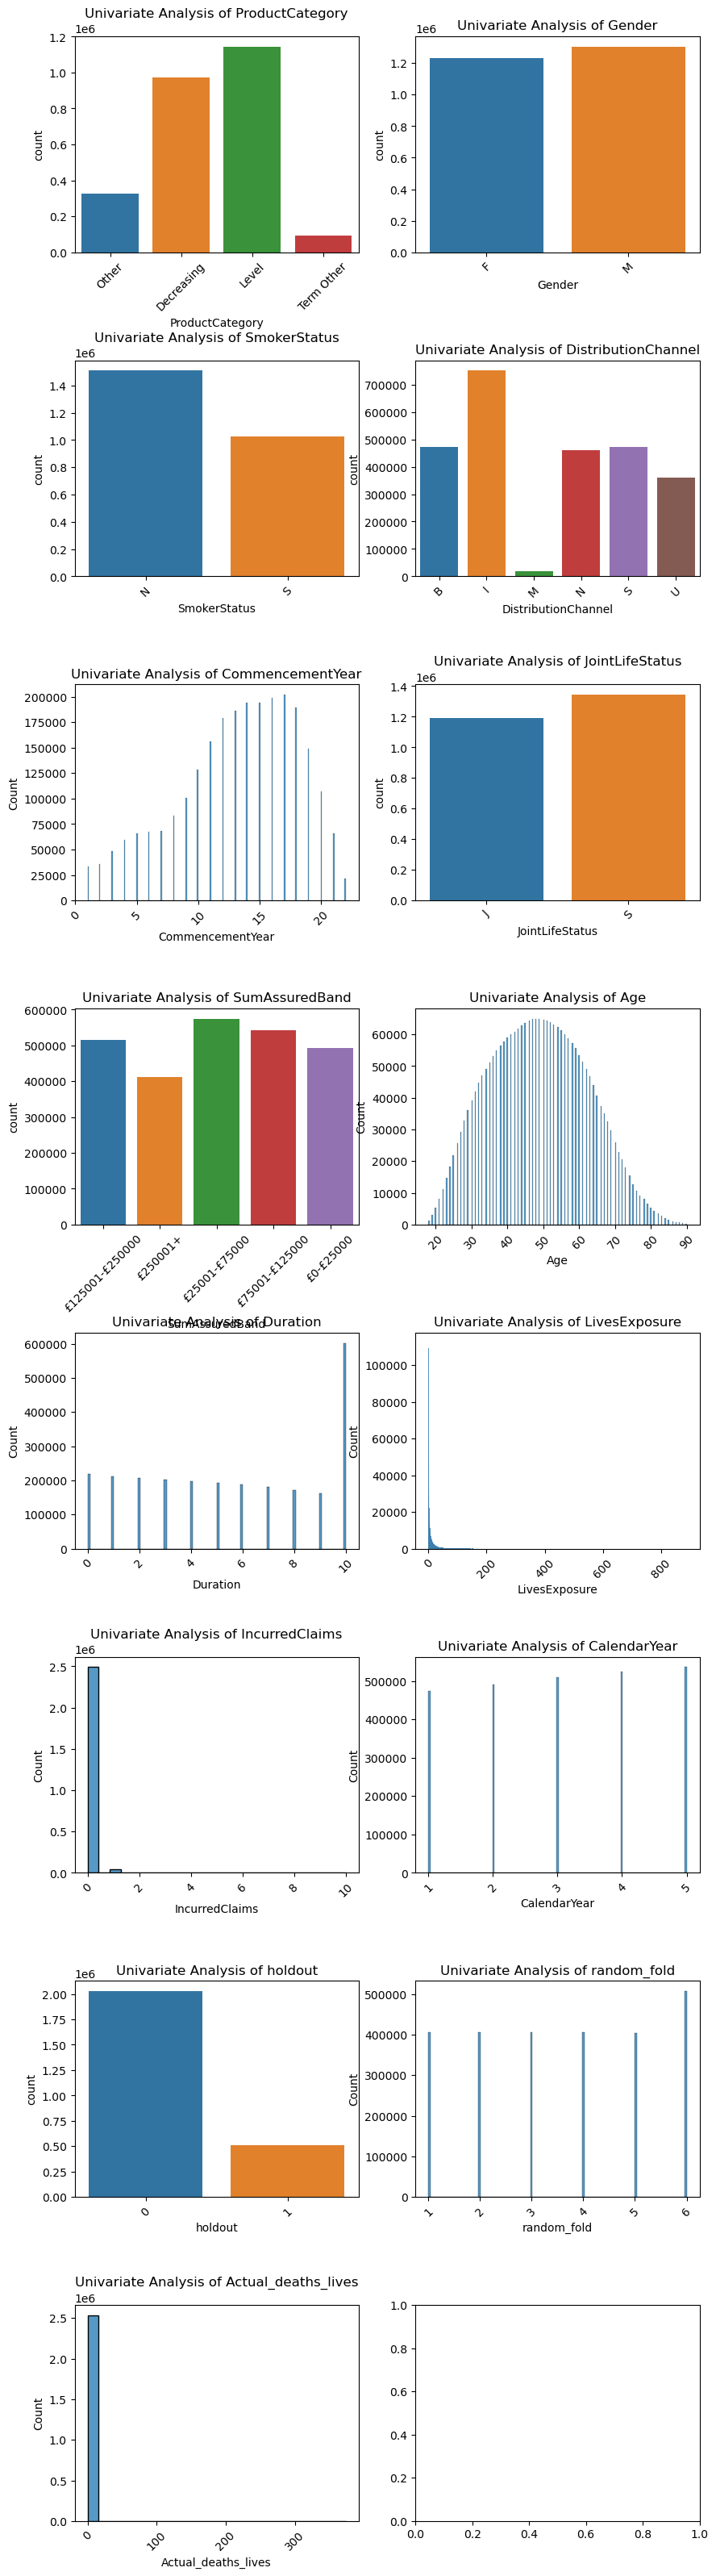

In [22]:
# Univariate plots

no_col = len(data.columns)
fig, axes = plt.subplots(nrows=(no_col // 2 + 1), ncols=2, figsize=(10, 40))
for i, column in enumerate(data.columns):
    if len(data[column].unique()) > 3 and pd.api.types.is_numeric_dtype(data[column]):
        ax = sns.histplot(data[column], ax=axes[i // 2, i % 2])
    else:
        ax = sns.countplot(x=column, data=data, ax=axes[i // 2, i % 2])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    axes[i // 2, i % 2].set_title(f"Univariate Analysis of {column}")
    plt.subplots_adjust(hspace=0.5)

plt.show()

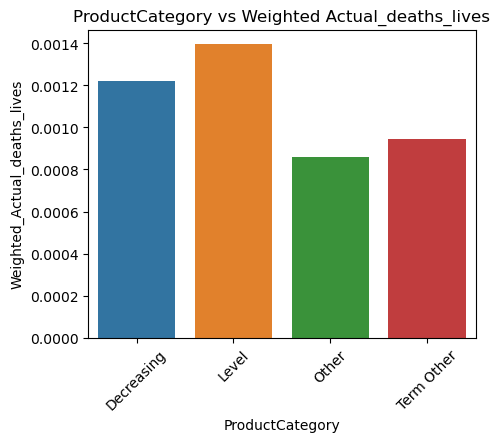

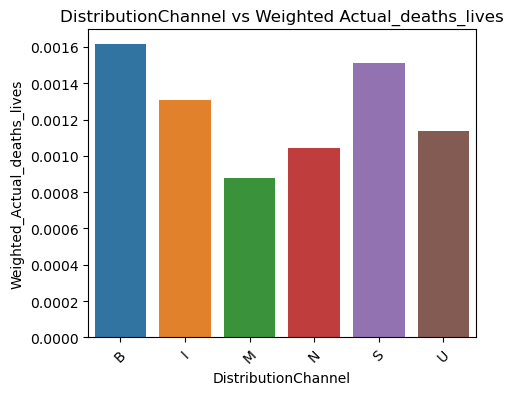

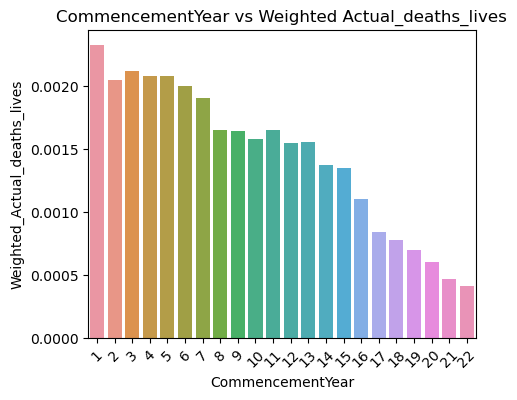

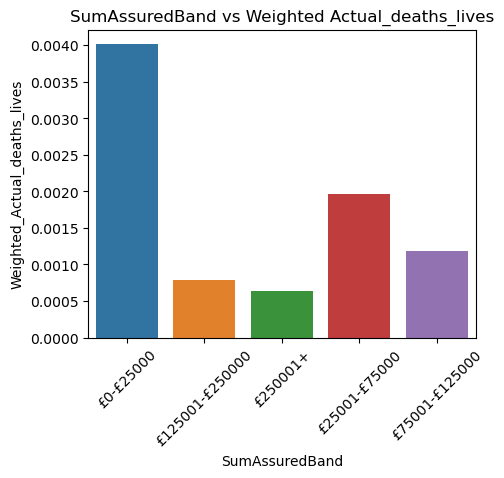

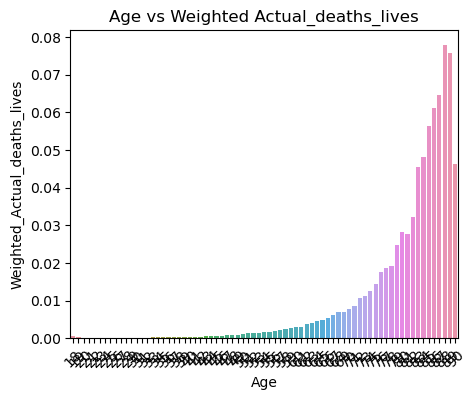

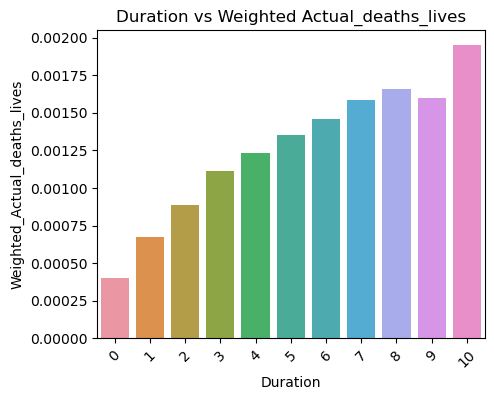

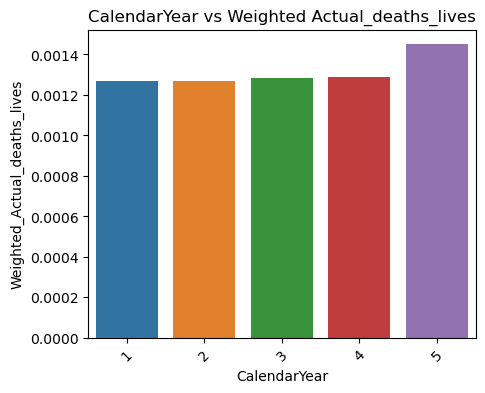

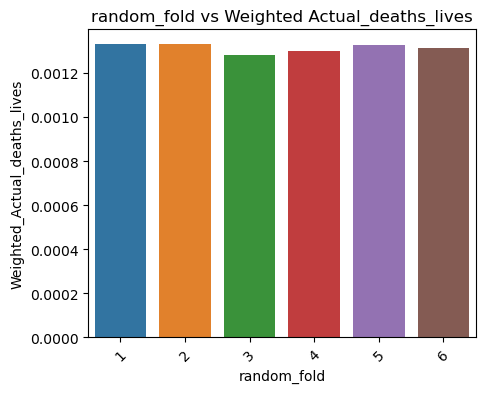

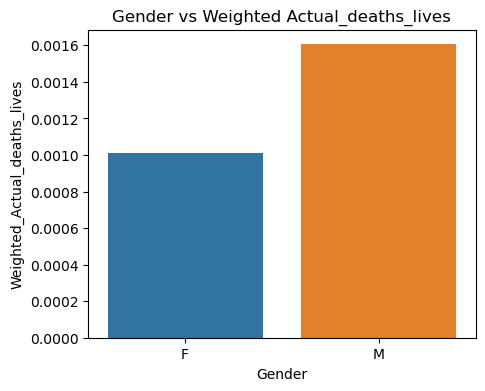

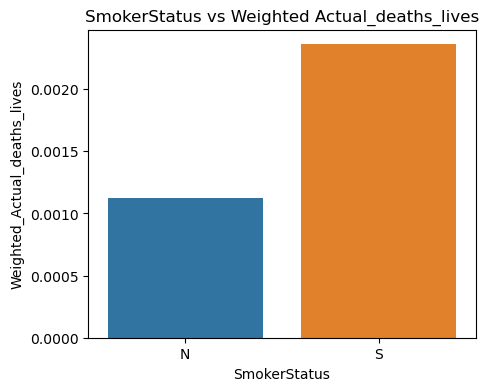

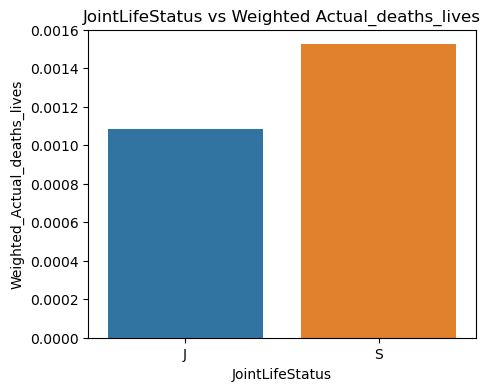

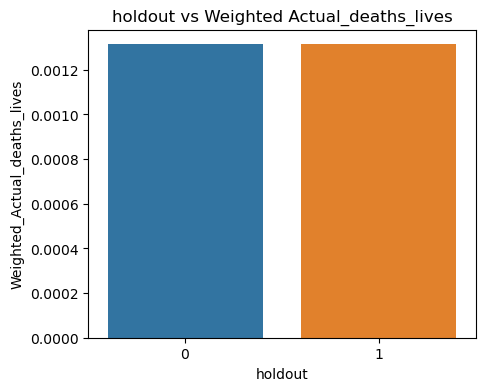

In [23]:
no_col = len(data.columns)
continuous_vars = []
categorical_vars = []
Target = "Actual_deaths_lives"
# data = data[data["Actual_deaths_lives"] <= 1]

for i, column in enumerate(data.drop([Target, "IncurredClaims"], axis=1).columns):
    if column == "LivesExposure":
        pass
    else:

        if len(data[column].unique()) > 3:
            continuous_vars.append(column)
        else:
            categorical_vars.append(column)


# Function to calculate weighted mean
def weighted_mean(df, value, weight):
    return (df[value] * df[weight]).sum() / df[weight].sum()


# Scatter plots for continuous variables vs target
for var in continuous_vars:
    plt.figure(figsize=(5, 4))
    weighted_data = (
        data[[var, Target, "LivesExposure"]]
        .groupby(var)
        .apply(lambda x: weighted_mean(x, Target, "LivesExposure"))
        .reset_index(name=f"Weighted_{Target}")
    )
    ax = sns.barplot(x=var, y=f"Weighted_{Target}", data=weighted_data)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.title(f"{var} vs Weighted {Target}")
    plt.show()

# Bar plots for categorical variables vs target
for var in categorical_vars:
    plt.figure(figsize=(5, 4))
    weighted_data = (
        data[[var, Target, "LivesExposure"]]
        .groupby(var)
        .apply(lambda x: weighted_mean(x, Target, "LivesExposure"))
        .reset_index(name=f"Weighted_{Target}")
    )
    ax = sns.barplot(x=var, y=f"Weighted_{Target}", data=weighted_data)
    plt.title(f"{var} vs Weighted {Target}")
    plt.show()

plt.show()

In [24]:
df_filtered = combined_df.drop(columns=["random_fold", "holdout"])

combined_df_encoded = pd.get_dummies(df_filtered, drop_first=True)

# Add the dropped columns back
combined_df_encoded["random_fold"] = combined_df["random_fold"]
combined_df_encoded["holdout"] = combined_df["holdout"]

In [25]:
combined_df_encoded = combined_df_encoded.apply(
    lambda x: x.astype(int) if x.dtypes == "bool" else x
)
combined_df_encoded.drop(
    ["Actual_deaths", "Expected_deaths", "Expected_deaths_lives"], axis=1, inplace=True
)

In [26]:
combined_df_encoded.dtypes

CommencementYear                    int64
Age                                 int64
Duration                            int64
LivesExposure                     float64
IncurredClaims                    float64
CalendarYear                        int64
Actual_deaths_lives               float64
ProductCategory_Level               int32
ProductCategory_Other               int32
ProductCategory_Term Other          int32
Gender_M                            int32
SmokerStatus_S                      int32
DistributionChannel_I               int32
DistributionChannel_M               int32
DistributionChannel_N               int32
DistributionChannel_S               int32
DistributionChannel_U               int32
JointLifeStatus_S                   int32
SumAssuredBand_£125001-£250000      int32
SumAssuredBand_£250001+             int32
SumAssuredBand_£25001-£75000        int32
SumAssuredBand_£75001-£125000       int32
random_fold                         int32
holdout                           

In [27]:
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm


df = combined_df_encoded.drop("Actual_deaths_lives", axis=1).copy()
df["LivesExposure"] = df["LivesExposure"].clip(
    lower=1e-6
)  # Ensure no zero or negative values

# Split data based on holdout column
train_df = df[df["holdout"] == 0]
test_df = df[df["holdout"] == 1]


X_train = train_df.drop(
    ["IncurredClaims", "LivesExposure", "holdout", "random_fold"], axis=1
)
y_train = train_df["IncurredClaims"]
X_test = test_df.drop(
    ["IncurredClaims", "LivesExposure", "holdout", "random_fold"], axis=1
)
y_test = test_df["IncurredClaims"]

# Add a constant term for the intercept
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the Poisson regression model with LivesExposure as an offset
poisson_model = sm.GLM(
    y_train,
    X_train,
    family=sm.families.Poisson(),
    offset=np.log(train_df["LivesExposure"]),
).fit()

# Print the summary of the model
print(poisson_model.summary())

# Predict on the test set
y_pred = poisson_model.predict(X_test, offset=np.log(test_df["LivesExposure"]))

# Show the predicted values along with the target values
predicted_vs_actual = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
print(predicted_vs_actual.head())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         IncurredClaims   No. Observations:              2028359
Model:                            GLM   Df Residuals:                  2028339
Model Family:                 Poisson   Df Model:                           19
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4232e+05
Date:                Thu, 14 Nov 2024   Deviance:                   2.1267e+05
Time:                        00:50:57   Pearson chi2:                 4.15e+06
No. Iterations:                     8   Pseudo R-squ. (CS):            0.02435
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

<Axes: >

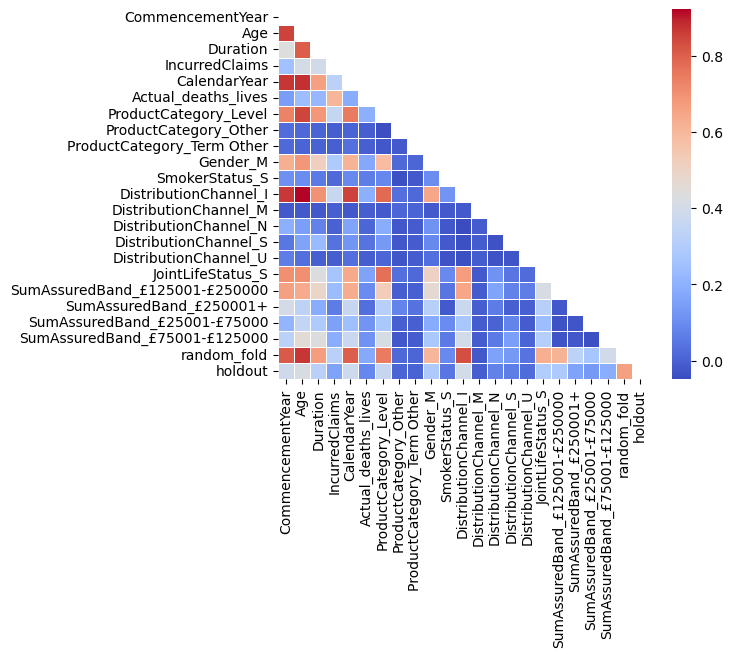

In [ ]:
def weighted_corr(df, weights):
    df_weighted = df.multiply(weights, axis=0)
    corr_matrix = df_weighted.corr()
    return corr_matrix


weights = combined_df_encoded["LivesExposure"]
df_for_corr = combined_df_encoded.drop(columns=["LivesExposure"])
weighted_corr_matrix = weighted_corr(df_for_corr, weights)

mask = np.triu(np.ones_like(weighted_corr_matrix, dtype=bool))

sns.heatmap(
    weighted_corr_matrix,
    mask=mask,
    cmap="coolwarm",
    annot=False,
    square=True,
    linewidths=0.5,
)

#####  There is collinearity between distribution channels , commencement year and probaly product category

In [30]:
combined_df_encoded.columns

Index(['CommencementYear', 'Age', 'Duration', 'LivesExposure',
       'IncurredClaims', 'CalendarYear', 'Actual_deaths_lives',
       'ProductCategory_Level', 'ProductCategory_Other',
       'ProductCategory_Term Other', 'Gender_M', 'SmokerStatus_S',
       'DistributionChannel_I', 'DistributionChannel_M',
       'DistributionChannel_N', 'DistributionChannel_S',
       'DistributionChannel_U', 'JointLifeStatus_S',
       'SumAssuredBand_£125001-£250000', 'SumAssuredBand_£250001+',
       'SumAssuredBand_£25001-£75000', 'SumAssuredBand_£75001-£125000',
       'random_fold', 'holdout'],
      dtype='object')

### Poisson distribution modelling

Input Layer
    |
    v
+---------------------+
| Original Features   |
+---------------------+
    |
    v
+---------------------+
| Interaction Terms   |
| (age, duration*,    |
|  calendar_year*)|
+---------------------+
    |
    v
+---------------------+
| Concatenation Layer |
+---------------------+
    |
    v
+---------------------+
| Fully Connected     |
| Layer               |
+---------------------+
    |
    v
+---------------------+
| Exp transform       |
+---------------------+
    |
    v
Output Layer


In [31]:
import pickle

with open("study_5fold_poissonv1.pkl", "rb") as f:
    study = pickle.load(f)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np


# combined_df_encoded = combined_df_encoded.drop("CommencementYear", axis=1)
df = combined_df_encoded.copy()
override = 1
if override == 1:
    Best_trial_params = {
        "lr": 0.18966738894449656,
        "weight_decay": 1.101170064867826e-05,
        "num_epochs": 987,
        "lambda_l1": 0.0001660810158279043,
        "age_cut": 47,
        "age_power": 2.640581163913133,
        "age_multiplier": 1,
    }
    lr = Best_trial_params["lr"]
    weight_decay = Best_trial_params["weight_decay"]
    num_epochs = Best_trial_params["num_epochs"]
    lambda_l1 = Best_trial_params["lambda_l1"]
    age_cut = Best_trial_params["age_cut"]
    age_power = Best_trial_params["age_power"]
    age_multiplier = Best_trial_params["age_multiplier"]
else:
        age_cut = study.best_params["age_cut"]  # 50
        age_power = study.best_params["age_power"]  # - 2  # 4.133448889716881  #
        weight_decay = study.best_params["weight_decay"]  # 1.0441166112064366e-05
        num_epochs = study.best_params["num_epochs"]  # 680
        lambda_l1 = study.best_params["lambda_l1"]
        lr = study.best_params["lr"]
        age_multiplier = study.best_params["age_multiplier"]
        print(f"read best params{study.best_params}")
   

df["Age2"] = (
    age_multiplier * np.maximum(df["Age"] - age_cut, 0) ** age_power
)  # np.exp(df['Age'])
df["LivesExposure"] = df["LivesExposure"].clip(
    lower=1e-6
)  # Ensure no zero or negative values;w we did filter out few cases earlier
train_df = df[df["holdout"] == 0]
test_df = df[df["holdout"] == 1]
train_lives_exposure = train_df["LivesExposure"]
test_lives_exposure = test_df["LivesExposure"]
X_train = train_df.drop(
    [
        "IncurredClaims",
        "LivesExposure",
        "Actual_deaths_lives",
        "holdout",
        "random_fold",
        "CommencementYear",
    ],
    axis=1,
)
y_train = train_df["IncurredClaims"]
X_test = test_df.drop(
    [
        "IncurredClaims",
        "LivesExposure",
        "Actual_deaths_lives",
        "holdout",
        "random_fold",
        "CommencementYear",
    ],
    axis=1,
)
y_test = test_df["IncurredClaims"]
age_test_tensor = torch.tensor(X_test["Age"].values, dtype=torch.float32)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

# Convert data to tensors
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

# Convert LivesExposure to tensors
lives_exposure_train_tensor = torch.tensor(
    train_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
)
lives_exposure_test_tensor = torch.tensor(
    test_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
)


# NN with custom interaction layer and offset
class Mort_Net(nn.Module):
    def __init__(self):
        super(Mort_Net, self).__init__()

        # Identify the indices of the specific columns
        self.age_idx = X_train_scaled.columns.get_loc("Age")
        self.duration_indices = [
            i
            for i, col in enumerate(X_train_scaled.columns)
            if col.startswith("Duration")
        ]
        self.commencement_year_indices = [
            i
            for i, col in enumerate(X_train_scaled.columns)
            if col.startswith("CalendarYear")
        ]
        # Define the fully connected layer
        interaction_input_size = len(self.duration_indices) + len(
            self.commencement_year_indices
        )
        self.fc2 = nn.Linear(
            len(X_train_scaled.columns) + interaction_input_size, 1
        )  # Include original features and interaction terms

    def forward(self, x, exposure):
        # Create interaction terms
        age_feature = x[:, self.age_idx].unsqueeze(1)
        interaction_terms = []  # torch.tensor(data=[], dtype=torch.float32)
        for idx in (
            self.duration_indices + self.commencement_year_indices  # + [self.age_idx]
        ):
            interaction_term = age_feature * x[:, idx].unsqueeze(1)
            interaction_terms.append(interaction_term)
            # print(interaction_term)

            # interaction_terms= torch.tensor(data=[], dtype=torch.float32)
            interaction_terms1 = torch.cat(interaction_terms, dim=1)
        # Concatenate the original features with interaction terms

        x_combined = torch.cat((x, interaction_terms1), dim=1)
        # print(f"x shape: {x.shape}")
        # print(f"interaction_terms1 shape: {interaction_terms1.shape}")
        # print(f"x_combined shape: {x_combined.shape}")

        # Final fully connected layer
        linear_output = self.fc2(x_combined)

        # Adding the log of the exposure as an offset
        offset_output = linear_output + torch.log(exposure)

        # Apply exponential activation for the poisson
        output = torch.exp(offset_output)

        return output


model = Mort_Net()
criterion = nn.PoissonNLLLoss(log_input=False)  # nn.MSELoss()#
optimizer = optim.Adam(
    model.parameters(), lr=lr, weight_decay=weight_decay
)  # Lower learning rate; weight decay acts to mimimise large weights like L2 regularisation


def l1_loss(model, lambda_l1):
    l1 = 0
    for param in model.parameters():
        l1 += torch.sum(torch.abs(param))
    return lambda_l1 * l1


for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor, lives_exposure_train_tensor)
    loss = criterion(outputs, y_train_tensor)  # + l1_loss(model, lambda_l1=0.00008)
    if torch.isnan(loss):
        print(f"Epoch {epoch+1}, Loss: NaN detected")
        break
    l1_reg = l1_loss(model, lambda_l1=lambda_l1)
    total_loss = loss + l1_reg
    total_loss.backward()
    optimizer.step()
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor, lives_exposure_test_tensor)
    loss = criterion(outputs, y_test_tensor)
    print(f"Test Loss: {loss.item()}")

Epoch 20, Loss: 0.5899431109428406
Epoch 40, Loss: 0.21444784104824066
Epoch 60, Loss: 0.15637722611427307
Epoch 80, Loss: 0.133710116147995
Epoch 100, Loss: 0.11986017227172852
Epoch 120, Loss: 0.10993493348360062
Epoch 140, Loss: 0.1024898812174797
Epoch 160, Loss: 0.09677949547767639
Epoch 180, Loss: 0.09231732785701752
Epoch 200, Loss: 0.08877076208591461
Epoch 220, Loss: 0.08591029047966003
Epoch 240, Loss: 0.08357289433479309
Epoch 260, Loss: 0.0816405639052391
Epoch 280, Loss: 0.08002658933401108
Epoch 300, Loss: 0.07866611331701279
Epoch 320, Loss: 0.07750992476940155
Epoch 340, Loss: 0.07652036100625992
Epoch 360, Loss: 0.07566800713539124
Epoch 380, Loss: 0.07492966949939728
Epoch 400, Loss: 0.07428687065839767
Epoch 420, Loss: 0.07372472435235977
Epoch 440, Loss: 0.07323110848665237
Epoch 460, Loss: 0.07279593497514725
Epoch 480, Loss: 0.07241133600473404
Epoch 500, Loss: 0.07207044959068298
Epoch 520, Loss: 0.07176751643419266
Epoch 540, Loss: 0.0714976117014885
Epoch 560, 

[I 2024-11-09 20:34:45,982] A new study created in memory with name: no-name-7cc95d96-e8ef-4e8f-a43a-bfe64d84a41b
[I 2024-11-09 20:41:02,677] Trial 0 finished with value: 781537.725 and parameters: {}. Best is trial 0 with value: 781537.725.
[I 2024-11-09 20:41:02,889] A new study created in memory with name: no-name-e86d11db-34bb-488f-ba21-3a49b8d12064


Mean Pseudo_R2: 781537.7250


[I 2024-11-09 20:47:35,409] Trial 0 finished with value: 561375.25 and parameters: {}. Best is trial 0 with value: 561375.25.
[I 2024-11-09 20:47:35,584] A new study created in memory with name: no-name-558821f5-973a-47ee-824a-cba9403cc829


Mean Pseudo_R2: 561375.2500


[I 2024-11-09 20:54:16,352] Trial 0 finished with value: 752426.35 and parameters: {}. Best is trial 0 with value: 752426.35.


Mean Pseudo_R2: 752426.3500


[I 2024-11-09 20:54:17,060] A new study created in memory with name: no-name-d0bd6fd7-cae4-4133-bdc7-723771ee3091
[I 2024-11-09 21:04:43,421] Trial 0 finished with value: 779553.45 and parameters: {}. Best is trial 0 with value: 779553.45.
[I 2024-11-09 21:04:43,611] A new study created in memory with name: no-name-f2d44df7-f38f-44e2-bc48-19a3c510f98f


Mean Pseudo_R2: 779553.4500


[I 2024-11-09 21:11:18,592] Trial 0 finished with value: 766757.7 and parameters: {}. Best is trial 0 with value: 766757.7.


Mean Pseudo_R2: 766757.7000


[I 2024-11-09 21:11:18,822] A new study created in memory with name: no-name-54c3ed19-267b-42fa-b4ee-aec8a1a2675a
[I 2024-11-09 21:22:38,359] Trial 0 finished with value: 778349.05 and parameters: {}. Best is trial 0 with value: 778349.05.
[I 2024-11-09 21:22:38,552] A new study created in memory with name: no-name-4459bdc5-bab9-4922-99c7-b58b791575c3


Mean Pseudo_R2: 778349.0500


[I 2024-11-09 21:29:04,810] Trial 0 finished with value: 780802.95 and parameters: {}. Best is trial 0 with value: 780802.95.


Mean Pseudo_R2: 780802.9500


[I 2024-11-09 21:29:05,020] A new study created in memory with name: no-name-12a5b13d-42ba-418c-86f6-4b5295b15e32
[I 2024-11-09 21:40:32,558] Trial 0 finished with value: 772771.85 and parameters: {}. Best is trial 0 with value: 772771.85.


Mean Pseudo_R2: 772771.8500


[I 2024-11-09 21:40:32,764] A new study created in memory with name: no-name-112cacf7-8690-44ca-ac89-8a67573f2ba9
[I 2024-11-09 21:46:56,361] Trial 0 finished with value: 718910.55 and parameters: {}. Best is trial 0 with value: 718910.55.
[I 2024-11-09 21:46:56,528] A new study created in memory with name: no-name-a591abef-0275-423d-b3f4-1de23ae4245f


Mean Pseudo_R2: 718910.5500


[I 2024-11-09 21:56:31,114] Trial 0 finished with value: 776644.95 and parameters: {}. Best is trial 0 with value: 776644.95.


Mean Pseudo_R2: 776644.9500


[I 2024-11-09 21:56:31,978] A new study created in memory with name: no-name-af7f2c86-5105-4231-8c17-16613020b41a
[I 2024-11-09 22:04:26,093] Trial 0 finished with value: 771276.85 and parameters: {}. Best is trial 0 with value: 771276.85.


Mean Pseudo_R2: 771276.8500


[I 2024-11-09 22:04:26,325] A new study created in memory with name: no-name-075c1767-a096-4337-9acc-668810be2e30
[I 2024-11-09 22:11:17,199] Trial 0 finished with value: 765406.0 and parameters: {}. Best is trial 0 with value: 765406.0.


Mean Pseudo_R2: 765406.0000


[I 2024-11-09 22:11:17,471] A new study created in memory with name: no-name-50de14ea-1224-47be-993e-dc2fcc3e9dab
[I 2024-11-09 22:24:20,952] Trial 0 finished with value: 777350.2 and parameters: {}. Best is trial 0 with value: 777350.2.


Mean Pseudo_R2: 777350.2000


[I 2024-11-09 22:24:21,631] A new study created in memory with name: no-name-ff61f78d-4a95-43bb-aae0-22d906bcf50f
[I 2024-11-09 22:41:58,270] Trial 0 finished with value: 770102.5 and parameters: {}. Best is trial 0 with value: 770102.5.


Mean Pseudo_R2: 770102.5000


[I 2024-11-09 22:41:58,606] A new study created in memory with name: no-name-74664da6-81ba-4940-bfd1-658e6ec873d8
[I 2024-11-09 22:56:01,672] Trial 0 finished with value: 775345.65 and parameters: {}. Best is trial 0 with value: 775345.65.


Mean Pseudo_R2: 775345.6500


[I 2024-11-09 22:56:02,690] A new study created in memory with name: no-name-507bf5e4-9584-40b5-8190-6d9ea6679418
[I 2024-11-09 23:02:54,023] Trial 0 finished with value: 775470.8 and parameters: {}. Best is trial 0 with value: 775470.8.
[I 2024-11-09 23:02:54,229] A new study created in memory with name: no-name-aa1ebcea-42ac-4b1f-bd09-d881cceae4ed


Mean Pseudo_R2: 775470.8000


[I 2024-11-09 23:09:39,144] Trial 0 finished with value: 780575.25 and parameters: {}. Best is trial 0 with value: 780575.25.


Mean Pseudo_R2: 780575.2500


[I 2024-11-09 23:09:39,371] A new study created in memory with name: no-name-2170be35-4024-4e8a-b205-2cb1c7e18f5e
[I 2024-11-09 23:16:15,200] Trial 0 finished with value: 777613.4 and parameters: {}. Best is trial 0 with value: 777613.4.


Mean Pseudo_R2: 777613.4000


[I 2024-11-09 23:16:15,462] A new study created in memory with name: no-name-be8a27d0-8eb6-48a8-9ec6-299a3fc75b38
[I 2024-11-09 23:23:15,431] Trial 0 finished with value: 779318.55 and parameters: {}. Best is trial 0 with value: 779318.55.


Mean Pseudo_R2: 779318.5500


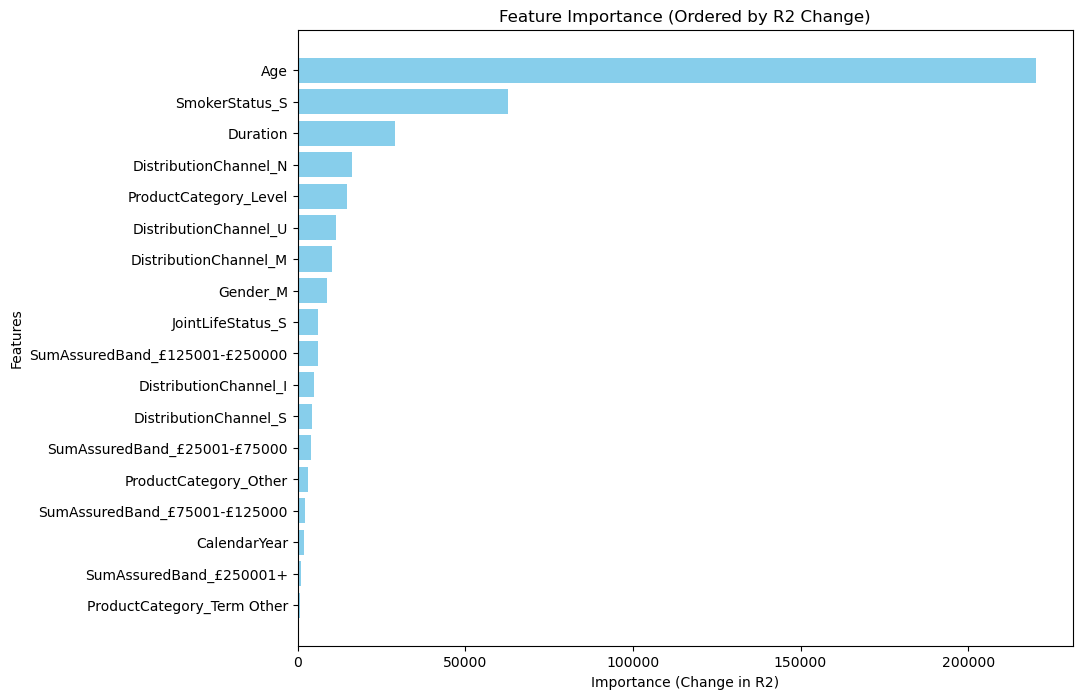

In [ ]:
import optuna

Best_trial_params = {
    "lr": 0.18966738894449656,
    "weight_decay": 1.101170064867826e-05,
    "num_epochs": 987,
    "lambda_l1": 0.0001660810158279043,
    "age_cut": 47,
    "age_power": 2.640581163913133,
    "age_multiplier": 1,
}


def objective(trial, features, df):
    global y_test_tensor
    global age_cut
    global age_power
    lr = Best_trial_params["lr"]  # trial.suggest_float("lr", 9e-2, 2e-1, log=True)
    weight_decay = Best_trial_params["weight_decay"]  # trial.suggest_float(
    #  "weight_decay", 1e-5, 1e-4, log=True
    # )  #
    num_epochs = Best_trial_params["num_epochs"]  # trial.suggest_int(
    #   "num_epochs", 900, 1200
    # )
    lambda_l1 = Best_trial_params[
        "lambda_l1"
    ]  # trial.suggest_float(   "lambda_l1", 1e-5, 1e-3, log=True    )  #
    age_cut = Best_trial_params["age_cut"]  # trial.suggest_int("age_cut", 20, 90)
    age_power = Best_trial_params[
        "age_power"
    ]  # trial.suggest_float("age_power", 1.3, 5)
    age_multiplier = Best_trial_params[
        "age_multiplier"
    ]  # trial.suggest_int("age_multiplier", 0, 1)
    pseudo_r2_scores = []

    # df = combined_df_encoded.copy()
    df = df[df["holdout"] == 0].copy()

    for fold in range(1, 6):  # only do 1 fold to speed up

        df.loc[:, "Age2"] = age_multiplier * (
            np.maximum(df["Age"] - age_cut, 0) ** age_power
        )
        df["LivesExposure"] = df["LivesExposure"].clip(
            lower=1e-6
        )  # Ensure no zero or negative values
        train_df = df[df["random_fold"] != fold]
        test_df = df[df["random_fold"] == fold]
        # print(df.columns)
        # Extract LivesExposure
        train_lives_exposure = train_df["LivesExposure"]
        test_lives_exposure = test_df["LivesExposure"]
        # Define features and target
        if "Age2" not in features:
            features.append("Age2")

        # print(f"features inside:{features}")
        X_train = train_df[features]
        y_train = train_df["IncurredClaims"]
        X_test = test_df[features]
        y_test = test_df["IncurredClaims"]
        # print(f"coliumns in objective:{X_train.columns}")
        # Scale the data
        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train), columns=X_train.columns
        )
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

        # Convert data to tensors
        X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(
            y_train.values.reshape(-1, 1), dtype=torch.float32
        )
        y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

        # Convert LivesExposure to tensors
        lives_exposure_train_tensor = torch.tensor(
            train_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
        )
        lives_exposure_test_tensor = torch.tensor(
            test_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
        )

        model = Mort_Net()
        criterion = nn.PoissonNLLLoss(log_input=False)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train_tensor, lives_exposure_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            l1_reg = l1_loss(model, lambda_l1=lambda_l1)
            total_loss = loss + l1_reg
            total_loss.backward()
            optimizer.step()

        # Evaluation
        model.eval()
        with torch.no_grad():
            outputs = model(X_test_tensor, lives_exposure_test_tensor)
            y_test_tensor = y_test_tensor + 1e-8
            weighted_mean_target = torch.sum(
                y_test_tensor * lives_exposure_test_tensor
            ) / torch.sum(lives_exposure_test_tensor)
            null_deviance = 2 * torch.sum(
                lives_exposure_test_tensor
                * (
                    y_test_tensor * torch.log(y_test_tensor / weighted_mean_target)
                    - (y_test_tensor - weighted_mean_target)
                )
            )

            # Weighted model deviance
            model_deviance = 2 * torch.sum(
                lives_exposure_test_tensor
                * (
                    y_test_tensor * torch.log(y_test_tensor / outputs)
                    - (y_test_tensor - outputs)
                )
            )
            pseudo_r2 = -model_deviance + null_deviance
            pseudo_r2_scores.append(pseudo_r2.item())

    mean_pseudo_r2 = np.mean(pseudo_r2_scores)
    print(f"Mean Pseudo_R2: {mean_pseudo_r2:.4f}")
    return mean_pseudo_r2


def evaluate_feature_importance(df, features):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, features, df), n_trials=1)
    best_trial = study.best_trial
    saturated_r2 = best_trial.value

    feature_importances = {}

    # Define one-hot encoded groups
    one_hot_groups = {
        "ProductCategory": [
            "ProductCategory_Level",
            "ProductCategory_Other",
            "ProductCategory_Term Other",
        ],
        "Gender": ["Gender_M"],
        "SmokerStatus": ["SmokerStatus_S"],
        "DistributionChannel": [
            "DistributionChannel_I",
            "DistributionChannel_M",
            "DistributionChannel_N",
            "DistributionChannel_S",
            "DistributionChannel_U",
        ],
        "JointLifeStatus": ["JointLifeStatus_S"],
        "SumAssuredBand": [
            "SumAssuredBand_£125001-£250000",
            "SumAssuredBand_£250001+",
            "SumAssuredBand_£25001-£75000",
            "SumAssuredBand_£75001-£125000",
        ],
    }

    for feature in features:
        if feature == "Age2":
            continue

        df_copy = df.copy()

        # Check if the feature is part of a one-hot encoded group
        group_found = False
        for group, group_features in one_hot_groups.items():
            if feature in group_features:
                group_found = True
                for gf in group_features:
                    if gf == feature:
                        df_copy[gf] = 1  # Set the current feature to 1
                    else:
                        df_copy[gf] = 0  # Set the other features in the group to 0
                break

        if not group_found:
            if feature not in (
                "Age",
                "Duration",
                "CalendarYear",
            ):  # Check if the feature is categorical
                df_copy[feature] = df_copy[feature].mode()[0]  # Replace with mode
            else:
                df_copy[feature] = df_copy[
                    feature
                ].mean()  # Replace with mean for numerical features

        study = optuna.create_study(direction="maximize")
        study.optimize(lambda trial: objective(trial, features, df_copy), n_trials=1)

        best_trial = study.best_trial
        current_r2 = best_trial.value

        feature_importances[feature] = saturated_r2 - current_r2

    return feature_importances


# Initial set of features
features = combined_df_encoded.columns.tolist()
features.remove("IncurredClaims")
features.remove("LivesExposure")
features.remove("Actual_deaths_lives")
features.remove("holdout")
features.remove("random_fold")
features.remove("CommencementYear")
data = combined_df_encoded  # .drop("CommencementYear", axis=1)
# Evaluate feature importance
features = [feature for feature in features if feature is not None]
feature_importances = evaluate_feature_importance(combined_df_encoded, features)

# Plotting the feature importances
sorted_features = sorted(feature_importances, key=feature_importances.get, reverse=True)
sorted_importances = [feature_importances[feature] for feature in sorted_features]

plt.figure(figsize=(10, 8))
plt.barh(sorted_features, sorted_importances, color="skyblue")
plt.xlabel("Importance (Change in R2)")
plt.ylabel("Features")
plt.title("Feature Importance (Ordered by R2 Change)")
plt.gca().invert_yaxis()
plt.show()

In [135]:
y_test_tensor = y_test_tensor + 1e-8
mean_target = torch.mean(y_test_tensor)
null_deviance = 2 * torch.sum(
    y_test_tensor * torch.log(y_test_tensor / mean_target)
    - (y_test_tensor - mean_target)
)
model_deviance = 2 * torch.sum(
    y_test_tensor * torch.log(y_test_tensor / outputs) - (y_test_tensor - outputs)
)
poisson_deviance = null_deviance - model_deviance
print(
    f"poisson deviance: {poisson_deviance}  psuedo R2 ={ 1- model_deviance/null_deviance}"
)
y_pred = outputs.numpy().flatten()

poisson deviance: 24086.91796875  psuedo R2 =0.3090548515319824


In [ ]:
test_df["Predicted_Claims"] = y_pred
filtered_combined_df = test_df  # combined_df.loc[combined_df.index.isin(test_df.index)]
# filtered_combined_df = filtered_combined_df.assign(
#    Predicted_Claims=test_df["Predicted_Claims"].values
# )
filtered_combined_df["Predicted_Claims_rate"] = (
    filtered_combined_df["Predicted_Claims"] / filtered_combined_df["LivesExposure"]
)

In [ ]:
filtered_combined_df["Predicted_Claims_rate"] = (
    filtered_combined_df["Predicted_Claims"] / filtered_combined_df["LivesExposure"]
)

##### plot of high level trends for predicted  followed by partial dependence plots( to be developed)

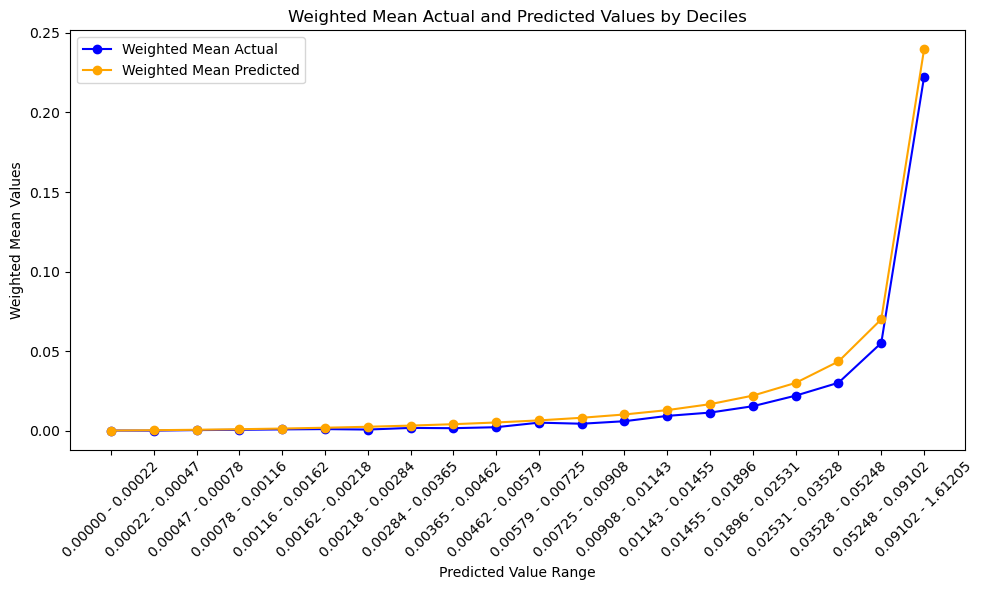

In [138]:
actual = y_test_tensor.numpy().flatten()
predicted = np.round(y_pred, 10)
weights2 = lives_exposure_test_tensor.numpy().flatten()

df_lift = pd.DataFrame({"actual": actual, "predicted": predicted, "weights": weights2})
df_lift = df_lift.sort_values(by="predicted", ascending=False)
# df_lift["Age"] = test_df["Age"]
# Create deciles
df_lift["decile"] = pd.qcut(df_lift["predicted"], 20, labels=False)


def weighted_mean(group):
    return pd.Series(
        {
            "weighted_actual": np.average(group["actual"], weights=group["weights"]),
            "weighted_predicted": np.average(
                group["predicted"], weights=group["weights"]
            ),
            "range": f"{group['predicted'].min():.5f} - {group['predicted'].max():.5f}",
        }
    )


decile_summary = df_lift.groupby("decile").apply(weighted_mean)

# Plot the weighted mean actual and predicted values for each decile
plt.figure(figsize=(10, 6))
plt.plot(
    decile_summary["weighted_actual"],
    label="Weighted Mean Actual",
    color="blue",
    marker="o",
)
plt.plot(
    decile_summary["weighted_predicted"],
    label="Weighted Mean Predicted",
    color="orange",
    marker="o",
)
plt.xlabel("Predicted Value Range")
plt.ylabel("Weighted Mean Values")
plt.title("Weighted Mean Actual and Predicted Values by Deciles")
plt.xticks(ticks=range(20), labels=decile_summary["range"], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
plt.show()

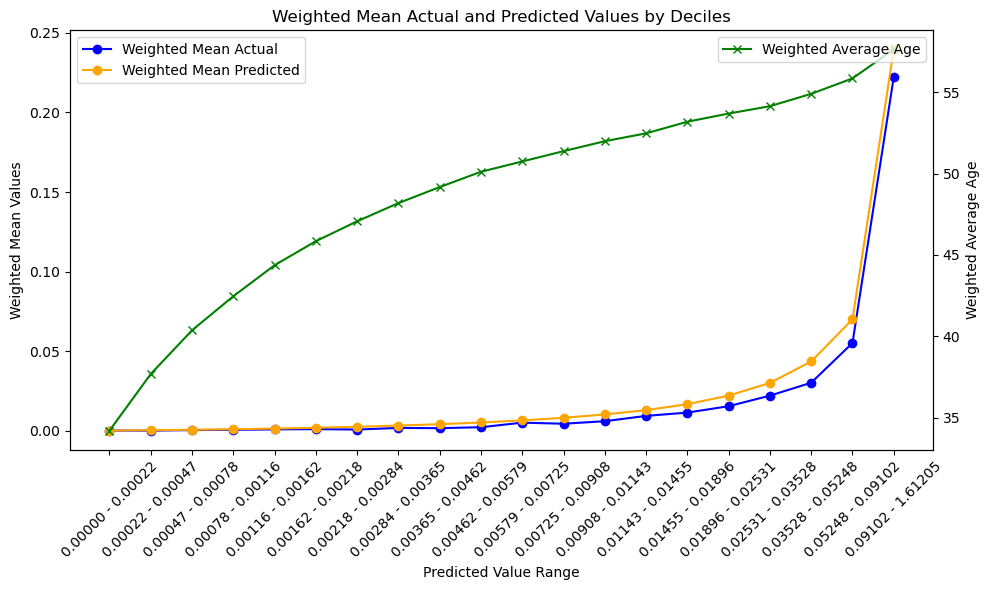

In [139]:
ages_original = age_test_tensor.numpy().flatten()
actual = y_test_tensor.numpy().flatten()
predicted = np.round(y_pred, 10)
weights2 = lives_exposure_test_tensor.numpy().flatten()

df_lift = pd.DataFrame(
    {
        "actual": actual,
        "predicted": predicted,
        "weights": weights2,
        "Age": ages_original,
    }
)
df_lift = df_lift.sort_values(by="predicted", ascending=False)


df_lift["decile"] = pd.qcut(df_lift["predicted"], 20, labels=False)


def weighted_mean(group):
    return pd.Series(
        {
            "weighted_actual": np.average(group["actual"], weights=group["weights"]),
            "weighted_predicted": np.average(
                group["predicted"], weights=group["weights"]
            ),
            "weighted_age": np.average(group["Age"]),  # , weights=group["weights"]),
            "range": f"{group['predicted'].min():.5f} - {group['predicted'].max():.5f}",
        }
    )


# Calculate weighted means for each decile
decile_summary = df_lift.groupby("decile").apply(weighted_mean)

# Plot the weighted mean actual and predicted values for each decile
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(
    decile_summary["weighted_actual"],
    label="Weighted Mean Actual",
    color="blue",
    marker="o",
)
ax1.plot(
    decile_summary["weighted_predicted"],
    label="Weighted Mean Predicted",
    color="orange",
    marker="o",
)
ax1.set_xlabel("Predicted Value Range")
ax1.set_ylabel("Weighted Mean Values")
ax1.set_title("Weighted Mean Actual and Predicted Values by Deciles")
ax1.set_xticks(ticks=range(20))
ax1.set_xticklabels(decile_summary["range"], rotation=45)
ax1.legend(loc="upper left")

# Create a secondary y-axis to plot the weighted average age
ax2 = ax1.twinx()
ax2.plot(
    decile_summary["weighted_age"],
    label="Weighted Average Age",
    color="green",
    marker="x",
)
ax2.set_ylabel("Weighted Average Age")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

In [140]:
weights_coeff = model.state_dict()
for layer_name, weights_coeff in weights_coeff.items():
    print(f"{layer_name}: {weights_coeff}")

fc2.weight: tensor([[ 8.0348e-01,  1.9471e-01,  1.7071e-05, -1.9305e-02,  1.0854e-01,
          3.5875e-02,  1.2175e-01,  4.3320e-01, -8.7060e-02,  4.0117e-02,
         -1.5240e-02, -5.7664e-05,  6.3464e-02,  1.4393e-02, -1.2516e-01,
         -1.0220e-01, -3.2979e-02, -8.0282e-02,  2.6556e-01, -3.1832e-02,
          1.5534e-04]])
fc2.bias: tensor([-6.3486])


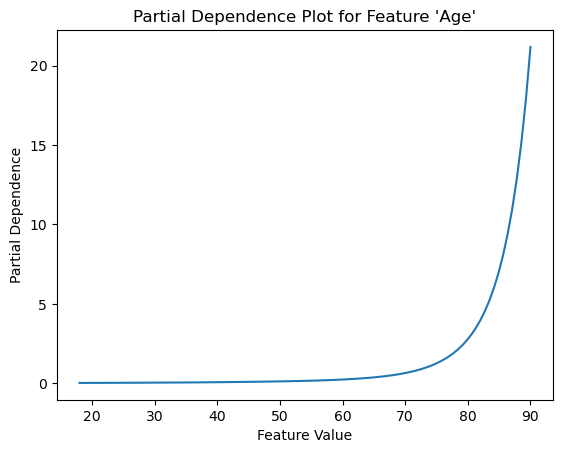

In [142]:
feature_index = X_train.columns.get_loc("Age")
feature_index2 = X_train.columns.get_loc("Age2")
grid_values = np.linspace(
    X_train.iloc[:, feature_index].min(), X_train.iloc[:, feature_index].max(), 100
)

partial_dependence = []
for val in grid_values:
    X_temp = X_train.copy()
    X_temp.iloc[:, feature_index] = val
    X_temp.iloc[:, feature_index2] = (
        age_multiplier * np.maximum(val - age_cut, 0) ** age_power
    )
    X_temp_scaled = scaler.transform(X_temp)

    model.eval()
    with torch.no_grad():
        preds = model(
            torch.tensor(X_temp_scaled, dtype=torch.float32),
            lives_exposure_train_tensor,
        )
        # pred_rate = preds / lives_exposure_train_tensor
        weighted_avg = torch.sum(preds * lives_exposure_train_tensor) / torch.sum(
            lives_exposure_train_tensor
        )
        partial_dependence.append(weighted_avg.item())

# Plot the partial dependence
plt.plot(grid_values, partial_dependence)
plt.xlabel("Feature Value")
plt.ylabel("Partial Dependence")
plt.title("Partial Dependence Plot for Feature 'Age'")
plt.show()

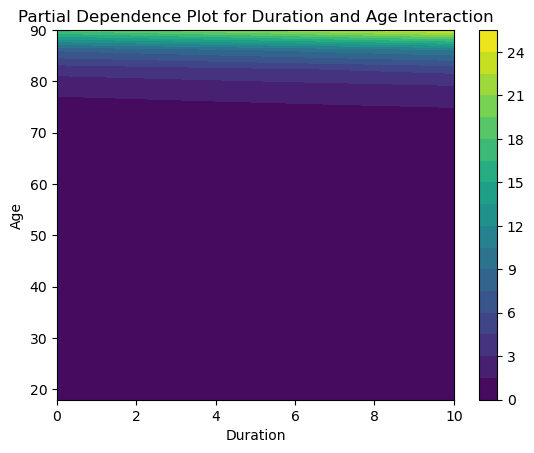

In [143]:
feature_index_duration = X_train.columns.get_loc("Duration")
feature_index_age = X_train.columns.get_loc("Age")
feature_index_age2 = X_train.columns.get_loc("Age2")

# Create a grid of values for Duration and Age
grid_values_duration = np.linspace(
    X_train.iloc[:, feature_index_duration].min(),
    X_train.iloc[:, feature_index_duration].max(),
    20,
)
grid_values_age = np.linspace(
    X_train.iloc[:, feature_index_age].min(),
    X_train.iloc[:, feature_index_age].max(),
    20,
)

# Initialize an array to store partial dependence values
partial_dependence = np.zeros((len(grid_values_duration), len(grid_values_age)))

# Compute partial dependence values
for i, val_duration in enumerate(grid_values_duration):
    for j, val_age in enumerate(grid_values_age):
        X_temp = X_train.copy()
        X_temp.iloc[:, feature_index_duration] = val_duration
        X_temp.iloc[:, feature_index_age] = val_age
        X_temp.iloc[:, feature_index_age2] = age_multiplier * (
            np.maximum(val_age - age_cut, 0) ** age_power
        )
        X_temp_scaled = scaler.transform(X_temp)

        model.eval()
        with torch.no_grad():
            y_pred = model(
                torch.tensor(X_temp_scaled, dtype=torch.float32),
                lives_exposure_train_tensor,
            )
            weights = lives_exposure_train_tensor.numpy().flatten()
            weighted_avg = np.sum(y_pred.numpy().flatten() * weights) / np.sum(weights)
            partial_dependence[i, j] = weighted_avg

# Plot the partial dependence
X, Y = np.meshgrid(grid_values_duration, grid_values_age)
plt.contourf(X, Y, partial_dependence.T, levels=20, cmap="viridis")
plt.colorbar()
plt.xlabel("Duration")
plt.ylabel("Age")
plt.title("Partial Dependence Plot for Duration and Age Interaction")
plt.show()

Other high level trends

In [ ]:
data = filtered_combined_df.drop(
    ["LivesExposure"],
    axis=1,
).copy()


no_col = len(data.columns)
continuous_vars = []
categorical_vars = []
Target = "Predicted_Claims_rate"
for i, column in enumerate(data.drop([Target], axis=1).columns):
    if len(data[column].unique()) > 25:
        continuous_vars.append(column)
    else:
        categorical_vars.append(column)


for var in continuous_vars:
    plt.figure(figsize=(5, 4))
    ax = sns.scatterplot(
        x=var,
        y=f"{Target}",
        data=data[[f"{var}", f"{Target}"]].groupby([f"{var}"]).mean().reset_index(),
    )

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.title(f"{var} vs {Target}")
    plt.show()

# Box plots for categorical variables vs target
for var in categorical_vars:
    plt.figure(figsize=(5, 4))
    ax = sns.barplot(
        x=var,
        y=f"{Target}",
        data=data[[f"{var}", f"{Target}"]].groupby([f"{var}"]).mean().reset_index(),
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.title(f"{var} vs {Target}")
    plt.show()

plt.show()

#### Model 2 : Zero inflation Poisson

In [ ]:
df = combined_df_encoded.copy()
other_best_params = {
    "lr": 0.035616594875214604,
    "weight_decay": 2.2553144169530133e-06,
    "num_epochs": 188,  # 178+40
    "lambda_l1": 0.00011023853559996378,
    "age_cut": 48,
    "age_power": 4.878640404260541,
    "age_multiplier": 1,
    "saturated_r2": 0.16814202070236206,
}

try:
    age_cut = other_best_params["age_cut"]  # 50
    age_power = other_best_params["age_power"]  # 4.133448889716881  #
    weight_decay = other_best_params["weight_decay"]  # 1.0441166112064366e-05
    num_epochs = other_best_params["num_epochs"]  # 680
    lambda_l1 = other_best_params["lambda_l1"]
    lr = other_best_params["lr"]
    age_multiplier = 1
    print("using other params")
except:
    pass

exclude_features = []
df = df.drop(columns=exclude_features)
df["Age2"] = (
    age_multiplier * np.maximum(df["Age"] - age_cut, 0) ** age_power
)  # np.exp(df['Age'])
df["LivesExposure"] = df["LivesExposure"].clip(
    lower=1e-6
)  # Ensure no zero or negative values;w we did filter out few cases earlier
train_df = df[df["holdout"] == 0]
test_df = df[df["holdout"] == 1]
train_lives_exposure = train_df["LivesExposure"]
test_lives_exposure = test_df["LivesExposure"]
X_train = train_df.drop(
    [
        "IncurredClaims",
        "LivesExposure",
        "Actual_deaths_lives",
        "holdout",
        "random_fold",
        "CommencementYear",
    ],
    axis=1,
)
y_train = train_df["IncurredClaims"]
X_test = test_df.drop(
    [
        "IncurredClaims",
        "LivesExposure",
        "Actual_deaths_lives",
        "holdout",
        "random_fold",
        "CommencementYear",
    ],
    axis=1,
)
y_test = test_df["IncurredClaims"]

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

# Convert data to tensors
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)
age_test_tensor = torch.tensor(X_test["Age"].values, dtype=torch.float32)
# Convert LivesExposure to tensors
lives_exposure_train_tensor = torch.tensor(
    train_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
)
lives_exposure_test_tensor = torch.tensor(
    test_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
)


class Mort_Net_ZIP(nn.Module):
    def __init__(self):
        super(Mort_Net_ZIP, self).__init__()

        # Identify the indices of the specific columns
        self.age_idx = X_train_scaled.columns.get_loc("Age")
        self.duration_indices = [
            i
            for i, col in enumerate(X_train_scaled.columns)
            if col.startswith("Duration")
        ]
        self.commencement_year_indices = [
            i
            for i, col in enumerate(X_train_scaled.columns)
            if col.startswith("CalendarYear")
        ]

        # Define the fully connected layers
        interaction_input_size = len(self.duration_indices) + len(
            self.commencement_year_indices
        )
        self.fc2 = nn.Linear(
            len(X_train_scaled.columns) + interaction_input_size, 1
        )  # Include original features and interaction terms

        # Additional layer for zero inflation
        self.fc_zero_inflation = nn.Linear(
            len(X_train_scaled.columns) + interaction_input_size, 1
        )

    def forward(self, x, exposure):
        # Create interaction terms
        age_feature = x[:, self.age_idx].unsqueeze(1)
        interaction_terms = []
        for idx in self.duration_indices + self.commencement_year_indices:
            interaction_term = age_feature * x[:, idx].unsqueeze(1)
            interaction_terms.append(interaction_term)
        interaction_terms1 = torch.cat(interaction_terms, dim=1)

        # Concatenate the original features with interaction terms
        x_combined = torch.cat((x, interaction_terms1), dim=1)

        # Final fully connected layer for Poisson part
        linear_output = self.fc2(x_combined)

        # Adding the log of the exposure as an offset
        offset_output = linear_output + torch.log(exposure)

        # Apply exponential activation for the Poisson part
        poisson_output = torch.exp(offset_output)

        # Zero inflation part
        zero_inflation_output = torch.sigmoid(self.fc_zero_inflation(x_combined))

        return poisson_output, zero_inflation_output


model = Mort_Net_ZIP()


def joint_loss(poisson_output, zero_inflation_output, y_true, exposure):
    # Poisson log-likelihood
    poisson_log_likelihood = (
        y_true * torch.log(poisson_output + 1e-8)
        - poisson_output
        - torch.lgamma(y_true + 1)
    )

    # Bernoulli log-likelihood for zero-inflation
    bernoulli_log_likelihood = y_true * torch.log(1 - zero_inflation_output + 1e-8) + (
        1 - y_true
    ) * torch.log(zero_inflation_output + 1e-8)

    # Joint log-likelihood
    joint_log_likelihood = poisson_log_likelihood + bernoulli_log_likelihood

    # Negative log-likelihood
    neg_log_likelihood = -torch.mean(joint_log_likelihood * exposure)

    return neg_log_likelihood


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


def l1_loss(model, lambda_l1):
    l1 = 0
    for param in model.parameters():
        l1 += torch.sum(torch.abs(param))
    return lambda_l1 * l1


criterion_poisson = nn.PoissonNLLLoss(log_input=False)
criterion_bernoulli = nn.BCELoss()
# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()
    poisson_outputs, zero_inflation_outputs = model(
        X_train_tensor, lives_exposure_train_tensor
    )

    # Calculate losses
    loss = joint_loss(
        poisson_outputs,
        zero_inflation_outputs,
        y_train_tensor,
        lives_exposure_train_tensor,
    )
    l1_reg = l1_loss(model, lambda_l1=lambda_l1)
    poisson_loss = criterion_poisson(poisson_outputs, y_train_tensor)
    bernoulli_loss = criterion_bernoulli(
        zero_inflation_outputs, (y_train_tensor == 0).float()
    )
    total_loss = poisson_loss + bernoulli_loss + l1_reg
    #    total_loss = loss + l1_reg
    total_loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(
            f"Epoch {epoch+1}, Joint Loss: {loss.item()}, Total Loss: {total_loss.item()}"
        )

model.eval()
with torch.no_grad():
    poisson_outputs, zero_inflation_outputs = model(
        X_test_tensor, lives_exposure_test_tensor
    )
    loss = joint_loss(
        poisson_outputs,
        zero_inflation_outputs,
        y_test_tensor,
        lives_exposure_test_tensor,
    )
    l1_reg = l1_loss(model, lambda_l1=lambda_l1)
    poisson_loss = criterion_poisson(poisson_outputs, y_test_tensor)
    bernoulli_loss = criterion_bernoulli(
        zero_inflation_outputs, (y_test_tensor == 0).float()
    )
    total_loss = poisson_loss + bernoulli_loss + l1_reg

    # total_loss = loss + l1_reg
    print(
        f"Test Poisson Loss: Joint Loss: {loss.item()}, Total Loss: {total_loss.item()}"
    )

contingency_table : IncurredClaims    False  True 
IncurredClaims                
False                 0  43836
True            2491613      0
Chi-squared statistic: 2535390.1433
P-value: 0.0000
The zero-inflation and Poisson processes are not independent (p < 0.05).
using other params
Epoch 20, Joint Loss: 166.02859497070312, Total Loss: 4.324154853820801
Epoch 40, Joint Loss: 98.20338439941406, Total Loss: 2.721997022628784
Epoch 60, Joint Loss: 71.75714874267578, Total Loss: 1.8985453844070435
Epoch 80, Joint Loss: 57.669681549072266, Total Loss: 1.4437310695648193
Epoch 100, Joint Loss: 47.15635681152344, Total Loss: 1.1545864343643188
Epoch 120, Joint Loss: 39.328861236572266, Total Loss: 0.9557403326034546
Epoch 140, Joint Loss: 33.65044021606445, Total Loss: 0.8120684623718262
Epoch 160, Joint Loss: 29.458240509033203, Total Loss: 0.7044231295585632
Epoch 180, Joint Loss: 26.24339485168457, Total Loss: 0.6214345693588257
Test Poisson Loss: Joint Loss: 25.091093063354492, Total 

In [122]:
# Assuming zero_inflation_outputs and poisson_outputs are your model's predictions
zero_inflation_probs = zero_inflation_outputs.detach().numpy().flatten()
poisson_means = poisson_outputs.detach().numpy().flatten()

# Create a contingency table
observed_zeros = (y_test_tensor.numpy().flatten() == 0).astype(int)
predicted_zeros = (zero_inflation_probs > 0.95).astype(int)

contingency_table = pd.crosstab(
    observed_zeros, predicted_zeros, rownames=["Observed"], colnames=["Predicted"]
)

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)

Chi-Square Statistic: 6456.270253262428
p-value: 0.0
Degrees of Freedom: 1
Expected Frequencies:
[[  3436.99055395   5295.00944605]
 [196158.00944605 302199.99055395]]


[I 2024-11-17 04:09:03,958] A new study created in memory with name: no-name-3bfd9488-dc11-4446-9151-c5d22b956a65
[I 2024-11-17 04:09:49,258] Trial 0 finished with value: 0.1892743706703186 and parameters: {}. Best is trial 0 with value: 0.1892743706703186.


Mean Pseudo_R2: 0.1893
best_trial_params {'saturated_r2': 0.1892743706703186}


[I 2024-11-17 04:09:49,477] A new study created in memory with name: no-name-86d38635-d9cb-4f3d-b78a-6f4b67af6df1
[I 2024-11-17 04:10:33,986] Trial 0 finished with value: 0.12918412685394287 and parameters: {}. Best is trial 0 with value: 0.12918412685394287.


Mean Pseudo_R2: 0.1292
trial params{}


[I 2024-11-17 04:10:34,255] A new study created in memory with name: no-name-01b86e17-7ba7-49d0-8920-134f39616bb0
[I 2024-11-17 04:11:18,181] Trial 0 finished with value: 0.18744343519210815 and parameters: {}. Best is trial 0 with value: 0.18744343519210815.


Mean Pseudo_R2: 0.1874
trial params{}


[I 2024-11-17 04:11:18,459] A new study created in memory with name: no-name-8b7f97e6-7286-4d01-920b-c7d22111cf3d
[I 2024-11-17 04:12:01,732] Trial 0 finished with value: 0.1754583716392517 and parameters: {}. Best is trial 0 with value: 0.1754583716392517.


Mean Pseudo_R2: 0.1755
trial params{}


[I 2024-11-17 04:12:01,983] A new study created in memory with name: no-name-d76e2ae2-016d-4e7f-83a9-9fea01cfdba4
[I 2024-11-17 04:12:45,926] Trial 0 finished with value: 0.1859188675880432 and parameters: {}. Best is trial 0 with value: 0.1859188675880432.


Mean Pseudo_R2: 0.1859
trial params{}


[I 2024-11-17 04:12:46,233] A new study created in memory with name: no-name-7a1ceacd-3b55-4a10-a566-54043dbbfb13
[I 2024-11-17 04:13:29,648] Trial 0 finished with value: 0.17869842052459717 and parameters: {}. Best is trial 0 with value: 0.17869842052459717.


Mean Pseudo_R2: 0.1787
trial params{}


[I 2024-11-17 04:13:29,931] A new study created in memory with name: no-name-02e2de78-c011-49d5-8e21-90f195a57e00
[I 2024-11-17 04:14:15,233] Trial 0 finished with value: 0.179307758808136 and parameters: {}. Best is trial 0 with value: 0.179307758808136.


Mean Pseudo_R2: 0.1793
trial params{}


[I 2024-11-17 04:14:15,508] A new study created in memory with name: no-name-f1f1ed33-6799-4761-bab2-de66005c73ec
[I 2024-11-17 04:15:01,860] Trial 0 finished with value: 0.17426198720932007 and parameters: {}. Best is trial 0 with value: 0.17426198720932007.


Mean Pseudo_R2: 0.1743
trial params{}


[I 2024-11-17 04:15:02,122] A new study created in memory with name: no-name-cb9408a1-df01-4853-b82f-a4bcedbb33b8
[I 2024-11-17 04:15:48,275] Trial 0 finished with value: 0.18361330032348633 and parameters: {}. Best is trial 0 with value: 0.18361330032348633.


Mean Pseudo_R2: 0.1836
trial params{}


[I 2024-11-17 04:15:48,556] A new study created in memory with name: no-name-3888c21b-545f-44f2-9306-76bcb21e4887
[I 2024-11-17 04:16:33,570] Trial 0 finished with value: 0.1994442343711853 and parameters: {}. Best is trial 0 with value: 0.1994442343711853.


Mean Pseudo_R2: 0.1994
trial params{}


[I 2024-11-17 04:16:33,856] A new study created in memory with name: no-name-43ec93cc-7ed7-492f-ab50-c4d6fd531f5e
[I 2024-11-17 04:17:18,470] Trial 0 finished with value: 0.20035696029663086 and parameters: {}. Best is trial 0 with value: 0.20035696029663086.


Mean Pseudo_R2: 0.2004
trial params{}


[I 2024-11-17 04:17:18,751] A new study created in memory with name: no-name-a22b6af0-0f60-481a-be2a-a892d9466e72
[I 2024-11-17 04:18:03,604] Trial 0 finished with value: 0.19500696659088135 and parameters: {}. Best is trial 0 with value: 0.19500696659088135.


Mean Pseudo_R2: 0.1950
trial params{}


[I 2024-11-17 04:18:03,916] A new study created in memory with name: no-name-459a085c-5e00-4c28-a8d1-b859be992ba0
[I 2024-11-17 04:18:48,169] Trial 0 finished with value: 0.19708257913589478 and parameters: {}. Best is trial 0 with value: 0.19708257913589478.


Mean Pseudo_R2: 0.1971
trial params{}


[I 2024-11-17 04:18:48,428] A new study created in memory with name: no-name-09d6bf1c-c092-4f17-aa60-77d12727d321
[I 2024-11-17 04:19:35,698] Trial 0 finished with value: 0.14340358972549438 and parameters: {}. Best is trial 0 with value: 0.14340358972549438.


Mean Pseudo_R2: 0.1434
trial params{}


[I 2024-11-17 04:19:35,912] A new study created in memory with name: no-name-998dd341-924f-4246-84c7-6d4197d018c5
[I 2024-11-17 04:20:21,178] Trial 0 finished with value: 0.17095941305160522 and parameters: {}. Best is trial 0 with value: 0.17095941305160522.


Mean Pseudo_R2: 0.1710
trial params{}


[I 2024-11-17 04:20:21,482] A new study created in memory with name: no-name-e0f18e17-c97c-48ac-bac2-371956b2104c
[I 2024-11-17 04:21:06,492] Trial 0 finished with value: 0.19432973861694336 and parameters: {}. Best is trial 0 with value: 0.19432973861694336.


Mean Pseudo_R2: 0.1943
trial params{}


[I 2024-11-17 04:21:06,778] A new study created in memory with name: no-name-b5409b13-cdfd-4f85-8613-2896a38b503f
[I 2024-11-17 04:21:54,642] Trial 0 finished with value: 0.19018858671188354 and parameters: {}. Best is trial 0 with value: 0.19018858671188354.


Mean Pseudo_R2: 0.1902
trial params{}


[I 2024-11-17 04:21:54,939] A new study created in memory with name: no-name-0953b379-f70a-4ad8-a89b-87129ce3e1a2
[I 2024-11-17 04:22:44,172] Trial 0 finished with value: 0.1914595365524292 and parameters: {}. Best is trial 0 with value: 0.1914595365524292.


Mean Pseudo_R2: 0.1915
trial params{}


[I 2024-11-17 04:22:44,475] A new study created in memory with name: no-name-44e228b5-ec9c-49cb-a100-1b07926b4d4f
[I 2024-11-17 04:23:32,186] Trial 0 finished with value: 0.16909265518188477 and parameters: {}. Best is trial 0 with value: 0.16909265518188477.


Mean Pseudo_R2: 0.1691
trial params{}


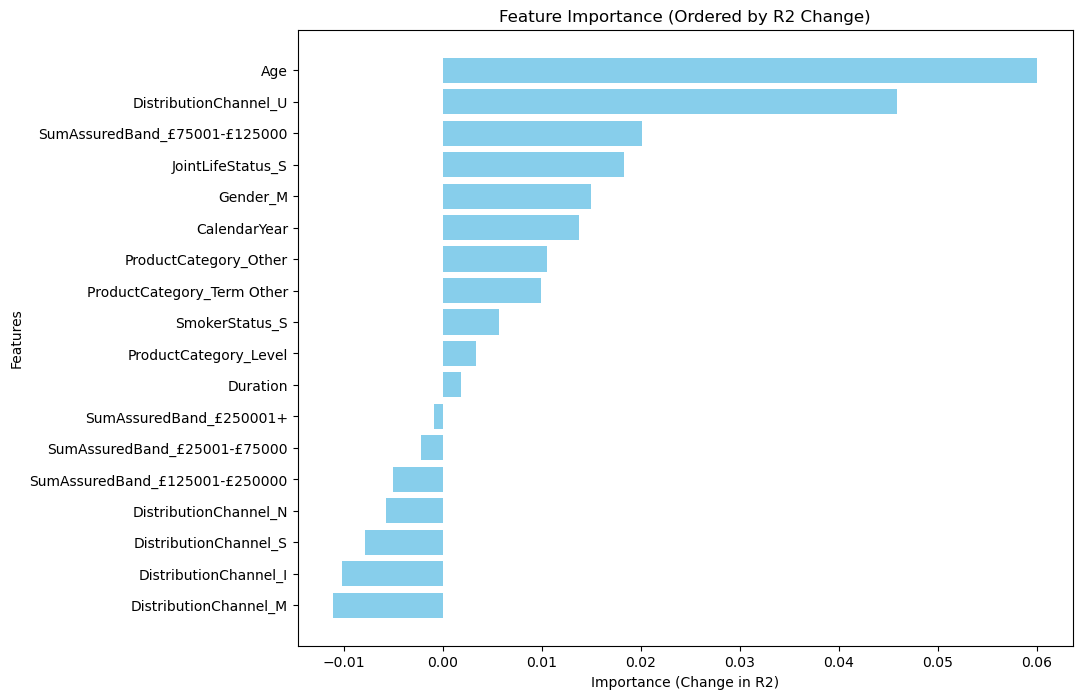

In [ ]:

best_trial_params = None


def objective(trial, features, df, best_trial_params=None):
    best_trial_params = {
        "lr": 0.02972705609808706,
        "weight_decay": 1.055699635897819e-05,
        "num_epochs": 224,
        "lambda_l1": 8.092090101858565e-05,
        "age_cut": 31,
        "age_power": 1.572813710364682,
        "age_multiplier": 1,
        "saturated_r2": 510630.1,
    }
    
    if best_trial_params:
        lr = best_trial_params["lr"]
        weight_decay = best_trial_params["weight_decay"]
        num_epochs = best_trial_params["num_epochs"]
        # lr = trial.suggest_float("lr", 1e-3, 2e-1, log=True)
        # weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
        # num_epochs = trial.suggest_int("num_epochs", 5, 500)
        # lambda_l1 = trial.suggest_float("lambda_l1", 1e-5, 1e-1, log=True)
        lambda_l1 = best_trial_params["lambda_l1"]
        age_cut = best_trial_params["age_cut"]
        age_power = best_trial_params["age_power"]
        age_multiplier = best_trial_params["age_multiplier"]
    else:
        lr = trial.suggest_float("lr", 1e-3, 2e-1, log=True)
        weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
        num_epochs = trial.suggest_int("num_epochs", 5, 500)
        lambda_l1 = trial.suggest_float("lambda_l1", 1e-5, 1e-1, log=True)
        age_cut = trial.suggest_int("age_cut", 20, 90)
        age_power = trial.suggest_float("age_power", 1.1, 5)
        age_multiplier = trial.suggest_int("age_multiplier", 0, 1)

    pseudo_r2_scores = []

    # df = df[df["holdout"] == 0].copy()

    for fold in range(1, 2):
        df["Age2"] = age_multiplier * np.maximum(df["Age"] - age_cut, 0) ** age_power
        df["LivesExposure"] = df["LivesExposure"].clip(lower=1e-6)
        train_df = df[df["holdout"] == 0]  # df[df["random_fold"] != fold]
        test_df = df[~(df["holdout"] == 0)]  # df[df["random_fold"] == fold]

        train_lives_exposure = train_df["LivesExposure"]
        test_lives_exposure = test_df["LivesExposure"]

        if "Age2" not in features:
            features.append("Age2")

        X_train = train_df[features]
        y_train = train_df["IncurredClaims"]
        X_test = test_df[features]
        y_test = test_df["IncurredClaims"]

        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train), columns=X_train.columns
        )
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

        X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(
            y_train.values.reshape(-1, 1), dtype=torch.float32
        )
        y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)
        lives_exposure_train_tensor = torch.tensor(
            train_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
        )
        lives_exposure_test_tensor = torch.tensor(
            test_lives_exposure.values.reshape(-1, 1), dtype=torch.float32
        )

        model = Mort_Net_ZIP()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            poisson_outputs, zero_inflation_outputs = model(
                X_train_tensor, lives_exposure_train_tensor
            )
            loss = joint_loss(
                poisson_outputs,
                zero_inflation_outputs,
                y_train_tensor,
                lives_exposure_train_tensor,
            )
            poisson_loss = criterion_poisson(poisson_outputs, y_train_tensor)
            bernoulli_loss = criterion_bernoulli(
                zero_inflation_outputs, (y_train_tensor == 0).float()
            )
            l1_reg = l1_loss(model, lambda_l1=lambda_l1)
            total_loss = poisson_loss + bernoulli_loss + l1_reg
            # total_loss = loss + l1_reg
            total_loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            poisson_outputs, zero_inflation_outputs = model(
                X_test_tensor, lives_exposure_test_tensor
            )
            y_pred = poisson_outputs * (1 - zero_inflation_outputs)
            y_test_tensor = y_test_tensor + 1e-8
            weighted_mean_target = torch.sum(
                y_test_tensor * lives_exposure_test_tensor
            ) / torch.sum(lives_exposure_test_tensor)
            null_deviance = 2 * torch.sum(
                lives_exposure_test_tensor
                * (
                    y_test_tensor * torch.log(y_test_tensor / weighted_mean_target)
                    - (y_test_tensor - weighted_mean_target)
                )
            )
            model_deviance = 2 * torch.sum(
                lives_exposure_test_tensor
                * (
                    y_test_tensor * torch.log(y_test_tensor / y_pred)
                    - (y_test_tensor - y_pred)
                )
            )
            pseudo_r2 = 1 - (model_deviance / null_deviance)
            pseudo_r2_scores.append(pseudo_r2.item())

    mean_pseudo_r2 = np.mean(pseudo_r2_scores)
    print(f"Mean Pseudo_R2: {mean_pseudo_r2:.4f}")
    return mean_pseudo_r2


def evaluate_feature_importance(df, features, best_trial_params):
    feature_importances = {}

    one_hot_groups = {
        "ProductCategory": [
            "ProductCategory_Level",
            "ProductCategory_Other",
            "ProductCategory_Term Other",
        ],
        "Gender": ["Gender_M"],
        "SmokerStatus": ["SmokerStatus_S"],
        "DistributionChannel": [
            "DistributionChannel_I",
            "DistributionChannel_M",
            "DistributionChannel_N",
            "DistributionChannel_S",
            "DistributionChannel_U",
        ],
        "JointLifeStatus": ["JointLifeStatus_S"],
        "SumAssuredBand": [
            "SumAssuredBand_£125001-£250000",
            "SumAssuredBand_£250001+",
            "SumAssuredBand_£25001-£75000",
            "SumAssuredBand_£75001-£125000",
        ],
    }

    for feature in features:
        if feature == "Age2":
            continue

        df_copy = df.copy()

        group_found = False
        for group, group_features in one_hot_groups.items():
            if feature in group_features:
                group_found = True
                for gf in group_features:
                    if gf == feature:
                        df_copy[gf] = 1
                    else:
                        df_copy[gf] = 0
                break

        if not group_found:
            if feature not in ("Age", "Duration", "CalendarYear"):
                df_copy[feature] = df_copy[feature].mode()[0]
            else:
                df_copy[feature] = df_copy[feature].mean()

        study = optuna.create_study(direction="maximize")
        study.optimize(
            lambda trial: objective(trial, features, df_copy, best_trial_params),
            n_trials=1,
        )
        best_trial = study.best_trial
        print(f"trial params{study.best_params}")
        current_r2 = best_trial.value
        feature_importances[feature] = best_trial_params["saturated_r2"] - current_r2

    return feature_importances


# Initial set of features
features = combined_df_encoded.columns.tolist()
features.remove("IncurredClaims")
features.remove("LivesExposure")
features.remove("Actual_deaths_lives")
features.remove("holdout")
features.remove("random_fold")
features.remove("CommencementYear")
data = combined_df_encoded

exclude_features = []
features = [feature for feature in features if feature not in exclude_features]
# Determine the best parameters using the saturated model
study = optuna.create_study(direction="maximize")
study.optimize(
    lambda trial: objective(trial, features, data), n_trials=1
)  # after first run set to 1
best_trial = study.best_trial
best_trial_params = best_trial.params
best_trial_params["saturated_r2"] = best_trial.value
print(f"best_trial_params {best_trial_params}")
# Evaluate feature importance using the best parameters

feature_importances = evaluate_feature_importance(
    combined_df_encoded, features, best_trial_params
)

sorted_features = sorted(feature_importances, key=feature_importances.get, reverse=True)
sorted_importances = [feature_importances[feature] for feature in sorted_features]

plt.figure(figsize=(10, 8))
plt.barh(sorted_features, sorted_importances, color="skyblue")
plt.xlabel("Importance (Change in R2)")
plt.ylabel("Features")
plt.title("Feature Importance (Ordered by R2 Change)")
plt.gca().invert_yaxis()
plt.show()

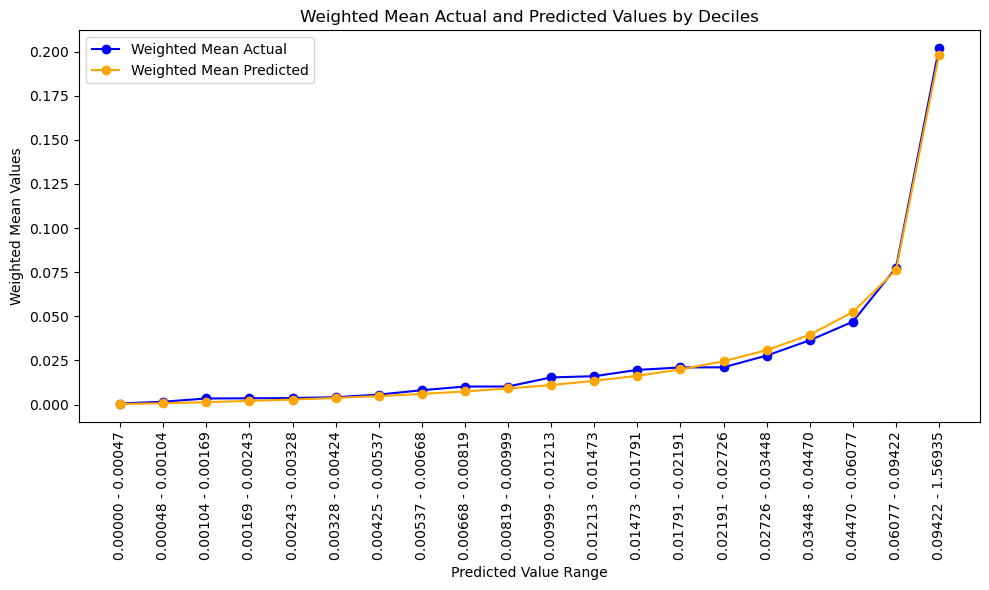

poisson deviance: 13629.829036072842  psuedo R2 =0.17488182747671788
fc2.weight: tensor([[ 0.0824,  0.0655,  0.0257, -0.2276,  0.4107,  0.2231, -0.0199,  0.6457,
         -0.5157,  0.0860,  0.0537,  0.1504,  0.3174, -0.0709, -0.2967, -0.0116,
         -0.1765, -0.2412,  0.3036, -0.4919, -0.0128]])
fc2.bias: tensor([-2.6171])
fc_zero_inflation.weight: tensor([[-0.1896, -0.0860, -0.0040, -0.1188,  0.1214,  0.0662, -0.0739,  0.0994,
         -0.2374, -0.0099,  0.0166,  0.0110,  0.0667, -0.0530, -0.0135,  0.0716,
         -0.0406, -0.0206,  0.0658,  0.1259, -0.0007]])
fc_zero_inflation.bias: tensor([3.0417])


In [130]:
model.eval()
with torch.no_grad():
    poisson_outputs, zero_inflation_outputs = model(
        X_test_tensor, lives_exposure_test_tensor
    )
    y_pred_poisson = poisson_outputs.numpy().flatten()
    y_pred_bernoulli = zero_inflation_outputs.numpy().flatten()

# Combine the Poisson and Bernoulli outputs to get the final predictions
y_pred = y_pred_poisson * (1 - y_pred_bernoulli)

# Flatten the actual values and weights
actual = y_test_tensor.numpy().flatten()
predicted = np.round(y_pred, 6)
weights = lives_exposure_test_tensor.numpy().flatten()
# Create a DataFrame for lift analysis
df_lift = pd.DataFrame({"actual": actual, "predicted": predicted, "weights": weights})
df_lift = df_lift.sort_values(by="predicted", ascending=False)
# df_lift["Age"] = X_test_scaled["Age"]
# Create deciles
df_lift["decile"] = pd.qcut(df_lift["predicted"], 20, labels=False)


def weighted_mean(group):
    return pd.Series(
        {
            "weighted_actual": np.average(group["actual"], weights=group["weights"]),
            "weighted_predicted": np.average(
                group["predicted"], weights=group["weights"]
            ),
            "range": f"{group['predicted'].min():.5f} - {group['predicted'].max():.5f}",
        }
    )


# Calculate weighted means for each decile
decile_summary = df_lift.groupby("decile").apply(weighted_mean)

# Plot the weighted mean actual and predicted values for each decile
plt.figure(figsize=(10, 6))
plt.plot(
    decile_summary["weighted_actual"],
    label="Weighted Mean Actual",
    color="blue",
    marker="o",
)
plt.plot(
    decile_summary["weighted_predicted"],
    label="Weighted Mean Predicted",
    color="orange",
    marker="o",
)
plt.xlabel("Predicted Value Range")
plt.ylabel("Weighted Mean Values")
plt.title("Weighted Mean Actual and Predicted Values by Deciles")
plt.xticks(ticks=range(20), labels=decile_summary["range"], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

actual = actual + 1e-8
mean_target = np.mean(actual)
null_deviance = 2 * sum(actual * np.log(actual / mean_target) - (actual - mean_target))
model_deviance = 2 * sum(actual * np.log(actual / y_pred) - (actual - y_pred))
poisson_deviance = null_deviance - model_deviance
print(
    f"poisson deviance: {poisson_deviance}  psuedo R2 ={ 1- model_deviance/null_deviance}"
)

weights = model.state_dict()
for layer_name, weight in weights.items():
    print(f"{layer_name}: {weight}")

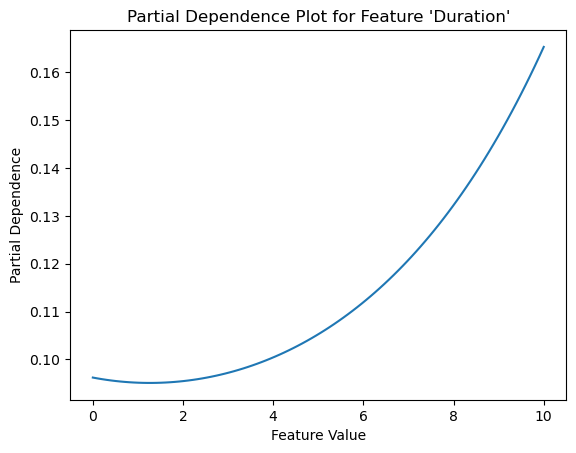

In [125]:
feature_index = X_train.columns.get_loc("Duration")
grid_values = np.linspace(
    X_train.iloc[:, feature_index].min(), X_train.iloc[:, feature_index].max(), 100
)

partial_dependence = []
for val in grid_values:
    X_temp = X_train.copy()
    X_temp.iloc[:, feature_index] = val
    X_temp_scaled = scaler.transform(X_temp)

    model.eval()
    with torch.no_grad():
        poisson_outputs, zero_inflation_outputs = model(
            torch.tensor(X_temp_scaled, dtype=torch.float32),
            lives_exposure_train_tensor,
        )
        y_pred_poisson = poisson_outputs.numpy().flatten()
        y_pred_bernoulli = zero_inflation_outputs.numpy().flatten()
        y_pred = y_pred_poisson * (1 - y_pred_bernoulli)

        weights = lives_exposure_train_tensor.numpy().flatten()
        weighted_avg = sum(y_pred * weights) / sum(weights)
        partial_dependence.append(weighted_avg.item())

# Plot the partial dependence
plt.plot(grid_values, partial_dependence)
plt.xlabel("Feature Value")
plt.ylabel("Partial Dependence")
plt.title(f"Partial Dependence Plot for Feature '{X_train.columns[feature_index]}'")
plt.show()

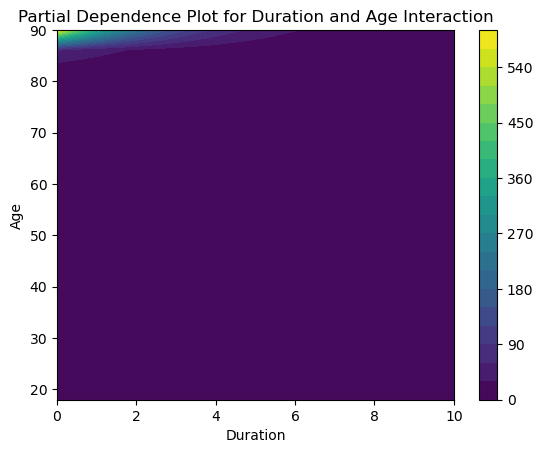

In [ ]:
feature_index_duration = X_train.columns.get_loc("CalendarYear")
feature_index_age = X_train.columns.get_loc("Age")
feature_index_age2 = X_train.columns.get_loc("Age2")

# Create a grid of values for Duration and Age
grid_values_duration = np.linspace(
    X_train.iloc[:, feature_index_duration].min(),
    X_train.iloc[:, feature_index_duration].max(),
    20,
)
grid_values_age = np.linspace(
    X_train.iloc[:, feature_index_age].min(),
    X_train.iloc[:, feature_index_age].max(),
    20,
)

# Initialize an array to store partial dependence values
partial_dependence = np.zeros((len(grid_values_duration), len(grid_values_age)))

# Compute partial dependence values
for i, val_duration in enumerate(grid_values_duration):
    for j, val_age in enumerate(grid_values_age):
        X_temp = X_train.copy()
        X_temp.iloc[:, feature_index_duration] = val_duration
        X_temp.iloc[:, feature_index_age] = val_age
        X_temp.iloc[:, feature_index_age2] = age_multiplier * (
            np.maximum(val_age - age_cut, 0) ** age_power
        )
        X_temp_scaled = scaler.transform(X_temp)

        model.eval()
        with torch.no_grad():
            poisson_outputs, zero_inflation_outputs = model(
                torch.tensor(X_temp_scaled, dtype=torch.float32),
                lives_exposure_train_tensor,
            )
            y_pred_poisson = poisson_outputs.numpy().flatten()
            y_pred_bernoulli = zero_inflation_outputs.numpy().flatten()
            y_pred = y_pred_poisson * (1 - y_pred_bernoulli)
            weights = lives_exposure_train_tensor.numpy().flatten()
            weighted_avg = np.sum(y_pred * weights) / np.sum(weights)
            partial_dependence[i, j] = weighted_avg

# Plot the partial dependence
X, Y = np.meshgrid(grid_values_duration, grid_values_age)
plt.contourf(X, Y, partial_dependence.T, levels=20, cmap="viridis")
plt.colorbar()
plt.xlabel("Duration")
plt.ylabel("Age")
plt.title("Partial Dependence Plot for Duration and Age Interaction")
plt.show()